In [1]:
!pip install numpy

In [2]:
!pip install sklearn

In [3]:
!pip install opencv_python

In [4]:
!pip install matplotlib

In [5]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
img = cv.imread(cv.samples.findFile('handwriting.jpg'),0)
if img is None:
    raise Exception("we need the digits.png image from samples/data here !")

In [7]:
nCols = 22
nRows = 7
cells = [np.hsplit(row,nCols) for row in np.vsplit(img,nRows)]

In [54]:
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [55]:
plt.imshow(cells[4][21], cmap='gray', vmin=0, vmax=255)

In [10]:
def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

In [11]:
def hog(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, ang = cv.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist

In [12]:
SZ=20
bin_n = 16 # Number of bins
affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR

In [370]:
# First half is trainData, remaining is testData
#train_cells = [ i[:nCols//2] for i in cells ]
#test_cells = [ i[nCols//2:] for i in cells]
train_cells = [ [im[2*i] for i in range(nCols//2)] for im in cells ]
test_cells = [ [im[2*i+1] for i in range(nCols//2)] for im in cells]
print(len(train_cells))

7


In [371]:
deskewed = [list(map(deskew,row)) for row in train_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
print(len(deskewed), len(hogdata))
trainData = np.float32(hogdata).reshape(-1,64)
responses = np.repeat(np.arange(nRows), nCols//2)[:,np.newaxis]

7 7


7 11


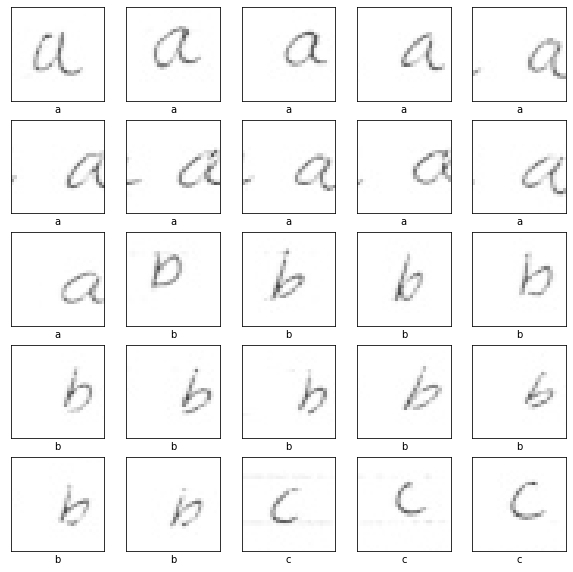

In [372]:
letter = ["a", "b", "c", "d", "e", "f", "g"]
print(len(train_cells), len(train_cells[0]))
plt.figure(figsize=(10,10))
for ite in range(25):
    i, j = ite//(nCols//2), ite%(nCols//2)
    plt.subplot(5, 5, ite + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_cells[i][j], cmap='gray', vmin=0, vmax=255)
    plt.xlabel(letter[responses[ite][0]])
plt.show()


In [373]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(trainData)
trainData = scaler.transform(trainData)

In [374]:
svm = cv.ml.SVM_create()
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setType(cv.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)

In [375]:
print(trainData.shape, responses.shape)

(77, 64) (77, 1)


In [376]:
svm.train(trainData, cv.ml.ROW_SAMPLE, responses)
svm.save('svm_data.dat')

In [377]:
deskewed = [list(map(deskew,row)) for row in test_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
testData = np.float32(hogdata).reshape(-1,bin_n*4)
testData = scaler.transform(testData)
result = svm.predict(testData)[1]

In [378]:
mask = result==responses
correct = np.count_nonzero(mask)
print(correct*100.0/result.size)

66.23376623376623


# kNN

In [379]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [380]:
neigh = KNN(n_neighbors = 3)
responsesKNN = responses.reshape(-1)
neigh.fit(trainData, responsesKNN)

KNeighborsClassifier(n_neighbors=3)

In [381]:
resultKNN = neigh.predict(testData)
resultKNN = resultKNN.reshape(resultKNN.shape[0], 1)
mask = resultKNN == responses
correct = np.count_nonzero(mask)
print(correct*100.0/len(resultKNN))

50.64935064935065


In [382]:
accs = []
ns = np.arange(1, 77)
for n in ns:
    neigh = KNN(n_neighbors = n)
    neigh.fit(trainData, responsesKNN)
    resultKNN = neigh.predict(testData)
    resultKNN = resultKNN.reshape(resultKNN.shape[0], 1)
    mask = resultKNN == responses
    accs.append(np.count_nonzero(mask)*100/len(resultKNN))
accs = np.array(accs)

In [383]:
fig = plt.figure()
plt.title("Accuracy as a function of n_neighbors, SKLearn")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy [%]")
plt.grid("true")
plt.plot(ns, accs)
plt.show()

# OpenCV

In [384]:
knnCV = cv.ml.KNearest_create()
knnCV.train(trainData, cv.ml.ROW_SAMPLE, responses)
ret, result, neighbors, dist = knnCV.findNearest(testData, k=5)

In [385]:
mask = result==responses
correct = np.count_nonzero(mask)
print(correct*100.0/result.size)

50.64935064935065


In [386]:
accs = []
for n in ns:
    ret, result, neighbors, dist = knnCV.findNearest(testData, k=n)
    mask = result==responses
    accs.append(np.count_nonzero(mask)*100/len(resultKNN))
accs = np.array(accs)

In [387]:
fig = plt.figure()
plt.title("Accuracy as a function of n_neighbors, OpenCV")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy [%]")
plt.grid("true")
plt.plot(ns, accs)
plt.show()

# Neural Network

In [388]:
!pip install Neurolab

In [389]:
import neurolab as nl
from sklearn.preprocessing import OneHotEncoder

In [390]:
responsesOneHot = responses.copy()
enc = OneHotEncoder(sparse = False)
out = enc.fit_transform(responsesOneHot)

In [391]:
print(trainData.max(), trainData.min())
net = nl.net.newff([[-2, 10]]*64, [10,7])
error_progress = net.train(trainData, out, epochs = 100, show = 10)

8.11232 -1.3866125
Epoch: 10; Error: 60.80657207247464;
Epoch: 20; Error: 25.806659221021793;
Epoch: 30; Error: 15.779511305694909;
Epoch: 40; Error: 10.55160717669134;
Epoch: 50; Error: 8.195696321335536;
Epoch: 60; Error: 6.8548651243127345;
Epoch: 70; Error: 5.648902220769014;
Epoch: 80; Error: 4.866002239262913;
Epoch: 90; Error: 4.288457095360933;
Epoch: 100; Error: 3.7890213785700255;
The maximum number of train epochs is reached


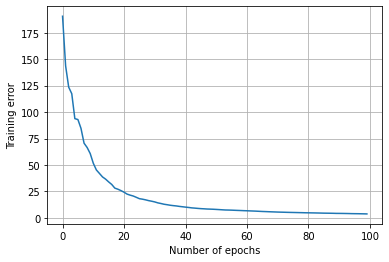

In [392]:
plt.figure()
plt.plot(error_progress)
plt.xlabel("Number of epochs")
plt.ylabel("Training error")
plt.grid()
plt.show()

In [393]:
pred = net.sim(testData)
predDecoded = []
for val in pred:
    predDecoded.append(np.where(val == val.max())[0])
predDecoded = (np.array(predDecoded)+1)%7

In [394]:
mask = predDecoded==responses
print(np.count_nonzero(mask)*100/len(predDecoded))


6.4935064935064934


In [396]:
epochs = range(0, 10)
accuracy = []

for epoch in epochs:
    net = nl.net.newff([[-2, 10]]*64, [10,7])
    error_progress = net.train(trainData, out, epochs = epoch, show = None)
    pred = net.sim(testData)
    predDecoded = []
    for val in pred:
        predDecoded.append(np.where(val == val.max())[0])
    predDecoded = (np.array(predDecoded)+1)%7
    mask = predDecoded==responses
    accuracy.append(np.count_nonzero(mask)*100/len(predDecoded))

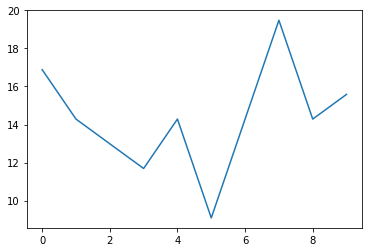

In [397]:
plt.figure()
plt.plot(epochs, accuracy)
plt.show()

# TensorFlow

In [398]:
!pip install tensorflow

In [399]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [400]:
train_data = np.array(train_cells)
test_data = np.array(test_cells)
train_data, test_data = train_data / 255, test_data / 255
train_data = train_data.reshape(train_data.shape[0]*train_data.shape[1], train_data.shape[2], train_data.shape[3],1)
imshape = train_data.shape
test_data = test_data.reshape(imshape)
print(train_data.shape, test_data.shape)

(77, 30, 30, 1) (77, 30, 30, 1)


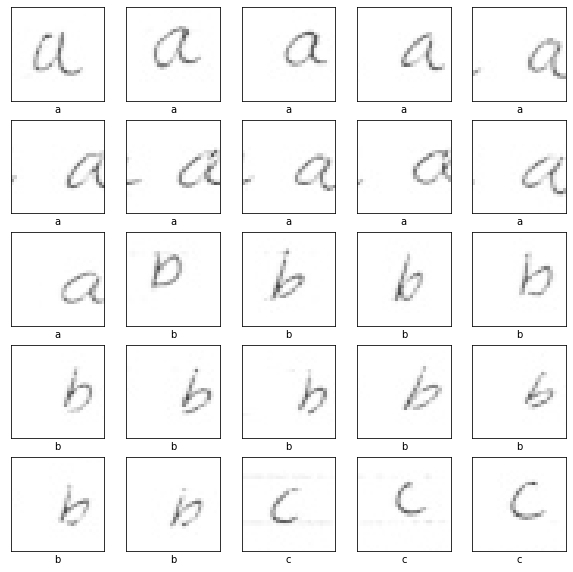

In [401]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i], cmap='gray', vmin=0, vmax=1)
    plt.xlabel(letter[responses[i][0]])
plt.show()

In [427]:
model = models.Sequential()
model.add(layers.Conv2D(30, (3, 3), activation="relu", input_shape=imshape[1:]))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))

In [428]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(len(letter)))

In [429]:
model.compile(optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])
history = model.fit(train_data, responses, epochs = 200, validation_data=(test_data, responses))

Epoch 1/200
3/3 [==============================] - 1s 116ms/step - loss: 1.9524 - accuracy: 0.1039 - val_loss: 1.9457 - val_accuracy: 0.1429
Epoch 2/200
3/3 [==============================] - 0s 28ms/step - loss: 1.9473 - accuracy: 0.1169 - val_loss: 1.9461 - val_accuracy: 0.1429
Epoch 3/200
3/3 [==============================] - 0s 30ms/step - loss: 1.9473 - accuracy: 0.1299 - val_loss: 1.9460 - val_accuracy: 0.1429
Epoch 4/200
3/3 [==============================] - 0s 33ms/step - loss: 1.9481 - accuracy: 0.1429 - val_loss: 1.9464 - val_accuracy: 0.1429
Epoch 5/200
3/3 [==============================] - 0s 32ms/step - loss: 1.9472 - accuracy: 0.1299 - val_loss: 1.9459 - val_accuracy: 0.1558
Epoch 6/200
3/3 [==============================] - 0s 28ms/step - loss: 1.9461 - accuracy: 0.1818 - val_loss: 1.9458 - val_accuracy: 0.1558
Epoch 7/200
3/3 [==============================] - 0s 29ms/step - loss: 1.9463 - accuracy: 0.0909 - val_loss: 1.9458 - val_accuracy: 0.1429
Epoch 8/200
3/3 [==

3/3 [==============================] - 0s 28ms/step - loss: 0.7279 - accuracy: 0.6494 - val_loss: 0.8296 - val_accuracy: 0.6494
Epoch 60/200
3/3 [==============================] - 0s 28ms/step - loss: 0.6354 - accuracy: 0.7662 - val_loss: 0.7597 - val_accuracy: 0.7532
Epoch 61/200
3/3 [==============================] - 0s 27ms/step - loss: 0.5754 - accuracy: 0.8442 - val_loss: 0.8114 - val_accuracy: 0.6494
Epoch 62/200
3/3 [==============================] - 0s 29ms/step - loss: 0.5579 - accuracy: 0.8182 - val_loss: 0.7654 - val_accuracy: 0.7532
Epoch 63/200
3/3 [==============================] - 0s 29ms/step - loss: 0.4419 - accuracy: 0.8052 - val_loss: 0.7731 - val_accuracy: 0.7273
Epoch 64/200
3/3 [==============================] - 0s 28ms/step - loss: 0.4428 - accuracy: 0.8571 - val_loss: 0.7491 - val_accuracy: 0.7143
Epoch 65/200
3/3 [==============================] - 0s 27ms/step - loss: 0.4023 - accuracy: 0.8831 - val_loss: 0.6793 - val_accuracy: 0.7792
Epoch 66/200
3/3 [========

3/3 [==============================] - 0s 28ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.7873 - val_accuracy: 0.8182
Epoch 118/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.7848 - val_accuracy: 0.8182
Epoch 119/200
3/3 [==============================] - 0s 28ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.7873 - val_accuracy: 0.8442
Epoch 120/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.7908 - val_accuracy: 0.8312
Epoch 121/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.7945 - val_accuracy: 0.8312
Epoch 122/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.8005 - val_accuracy: 0.8312
Epoch 123/200
3/3 [==============================] - 0s 31ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.8060 - val_accuracy: 0.8312
Epoch 124/200
3/3 [=

Epoch 175/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.9113 - val_accuracy: 0.8312
Epoch 176/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9138 - val_accuracy: 0.8312
Epoch 177/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9162 - val_accuracy: 0.8312
Epoch 178/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9167 - val_accuracy: 0.8442
Epoch 179/200
3/3 [==============================] - 0s 29ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9157 - val_accuracy: 0.8442
Epoch 180/200
3/3 [==============================] - 0s 33ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9151 - val_accuracy: 0.8442
Epoch 181/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9146 - val_accuracy: 0.8312
Epoch 

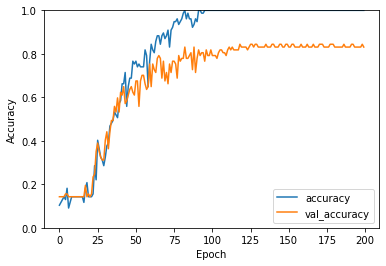

3/3 - 0s - loss: 0.9353 - accuracy: 0.8312 - 26ms/epoch - 9ms/step


In [430]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()
test_loss, test_acc = model.evaluate(test_data, responses, verbose=2)

# Enhance the dataset to increase diversity

In [475]:
!pip install tensorflow_addons

In [476]:
import tensorflow_addons as tfa
import random

def bootStrap(data, labels, n):
    new_data = []
    new_labels = []
    for i in range(n):
        index = random.randint(0, len(data) - 1)
        aug_data = tf.cast(data[index], tf.float32)
        aug_data = tfa.image.transform_ops.rotate(aug_data, 1)
        aug_data = tf.image.adjust_brightness(data[index], random.random())
        aug_data = tf.image.central_crop(aug_data, central_fraction=random.uniform(0.5,1))
        aug_data = tf.image.resize(aug_data, [30, 30])
        new_data.append(aug_data)
        new_labels.append(labels[index])
    return np.array(new_data), np.array(new_labels)
    

In [477]:
train_data_bootstrapped, responses_bootstrapped = bootStrap(train_data, responses, 1000)
print(train_data_bootstrapped.shape)

(1000, 30, 30, 1)


In [478]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=imshape[1:]))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(len(letter)))

In [479]:
model.compile(optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])
history = model.fit(train_data_bootstrapped, responses_bootstrapped, epochs = 100, validation_data=(test_data, responses))

Epoch 1/100
32/32 [==============================] - 1s 21ms/step - loss: 1.9505 - accuracy: 0.1630 - val_loss: 1.9528 - val_accuracy: 0.1429
Epoch 2/100
32/32 [==============================] - 1s 16ms/step - loss: 1.9440 - accuracy: 0.1700 - val_loss: 1.9465 - val_accuracy: 0.1429
Epoch 3/100
32/32 [==============================] - 1s 16ms/step - loss: 1.9427 - accuracy: 0.1730 - val_loss: 1.9498 - val_accuracy: 0.1429
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 1.9431 - accuracy: 0.1730 - val_loss: 1.9502 - val_accuracy: 0.1429
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 1.9437 - accuracy: 0.1730 - val_loss: 1.9479 - val_accuracy: 0.1429
Epoch 6/100
32/32 [==============================] - 1s 16ms/step - loss: 1.9417 - accuracy: 0.1730 - val_loss: 1.9492 - val_accuracy: 0.1429
Epoch 7/100
32/32 [==============================] - 0s 16ms/step - loss: 1.9425 - accuracy: 0.1730 - val_loss: 1.9470 - val_accuracy: 0.1429
Epoch 

32/32 [==============================] - 1s 16ms/step - loss: 8.4926e-04 - accuracy: 1.0000 - val_loss: 2.3142 - val_accuracy: 0.7403
Epoch 59/100
32/32 [==============================] - 0s 16ms/step - loss: 8.0654e-04 - accuracy: 1.0000 - val_loss: 2.3333 - val_accuracy: 0.7403
Epoch 60/100
32/32 [==============================] - 0s 16ms/step - loss: 7.0139e-04 - accuracy: 1.0000 - val_loss: 2.3542 - val_accuracy: 0.7403
Epoch 61/100
32/32 [==============================] - 1s 17ms/step - loss: 6.4292e-04 - accuracy: 1.0000 - val_loss: 2.3614 - val_accuracy: 0.7403
Epoch 62/100
32/32 [==============================] - 1s 16ms/step - loss: 5.6997e-04 - accuracy: 1.0000 - val_loss: 2.3735 - val_accuracy: 0.7403
Epoch 63/100
32/32 [==============================] - 0s 16ms/step - loss: 5.6494e-04 - accuracy: 1.0000 - val_loss: 2.3879 - val_accuracy: 0.7403
Epoch 64/100
32/32 [==============================] - 1s 16ms/step - loss: 5.2252e-04 - accuracy: 1.0000 - val_loss: 2.3844 - val_a

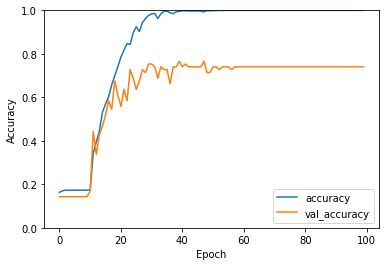

3/3 - 0s - loss: 2.6903 - accuracy: 0.7403 - 29ms/epoch - 10ms/step


In [480]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()
test_loss, test_acc = model.evaluate(test_data, responses, verbose=2)

In [481]:
hist_arr = np.array(history.history["val_accuracy"])
optimal_epoch = np.where(hist_arr == hist_arr.max())[0][0]

In [482]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=imshape[1:]))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(len(letter)))
model.compile(optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])
history = model.fit(train_data_bootstrapped, responses_bootstrapped, epochs = optimal_epoch, validation_data=(test_data, responses))

Epoch 1/39
32/32 [==============================] - 1s 22ms/step - loss: 1.9501 - accuracy: 0.1550 - val_loss: 1.9461 - val_accuracy: 0.1429
Epoch 2/39
32/32 [==============================] - 1s 16ms/step - loss: 1.9426 - accuracy: 0.1730 - val_loss: 1.9462 - val_accuracy: 0.1429
Epoch 3/39
32/32 [==============================] - 1s 16ms/step - loss: 1.9460 - accuracy: 0.1730 - val_loss: 1.9464 - val_accuracy: 0.1429
Epoch 4/39
32/32 [==============================] - 1s 16ms/step - loss: 1.9460 - accuracy: 0.1730 - val_loss: 1.9466 - val_accuracy: 0.1429
Epoch 5/39
32/32 [==============================] - 1s 17ms/step - loss: 1.9434 - accuracy: 0.1730 - val_loss: 1.9470 - val_accuracy: 0.1429
Epoch 6/39
32/32 [==============================] - 1s 17ms/step - loss: 1.9435 - accuracy: 0.1730 - val_loss: 1.9480 - val_accuracy: 0.1429
Epoch 7/39
32/32 [==============================] - 1s 16ms/step - loss: 1.9421 - accuracy: 0.1730 - val_loss: 1.9479 - val_accuracy: 0.1429
Epoch 8/39
32

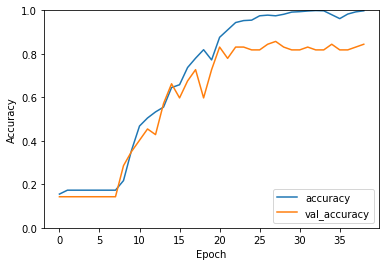

3/3 - 0s - loss: 0.6387 - accuracy: 0.8442 - 26ms/epoch - 9ms/step


In [483]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()
test_loss, test_acc = model.evaluate(test_data, responses, verbose=2)